# Calculation of Master Bias with CCDPROC
==================================================================

### Author : Sylvie Dagoret-Campagne
### Affiliation : LAL,IN2P3,CNRS
### Creation : Monday May 30th 2016
### Update : May 31th 2016

## CCD reduction for Monocam data (LSST)

The calculation is done by **ccdproc** python package.

http://ccdproc.readthedocs.io/en/latest/index.html


https://github.com/astropy/ccdproc/blob/master/docs/ccdproc/reduction_toolbox.rst


In [1]:
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
#config InlineBackend.rc = {}
#config Backend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")  # default config obtained from astropy examples
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from astropy.io import fits
from astropy import units as u
import ccdproc
from scipy import stats  
import os

In [3]:
from datetime import datetime, timedelta

In [4]:
def BuildFilelist(path,name,ext='.fits',start=1,stop=99):
    '''
    Make the list of filenames required by ccdproc
    
    input:
       path : path of files
       name : common root of bias filenames
       ext  : extension of filenames
       start,stop : indexes of files
    output:
       full filename list
    '''
    filelist = []
    for num in range(start,stop+1,1):
        strnum=biasnumberstr= '{0:02d}'.format(num)  # python >= 2.6
        filename=name+strnum+ext
        fullfilename=os.path.join(path,filename)
        filelist.append(fullfilename)
    return filelist

## 1) Definition of configuration variables

### 1.1) choose the inputs

In [5]:
root_filename='bias_'
ext_filename='.fits'
startnum=1
stopnum=50
path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160509'
nb_of_channels=16  # number of CCD amplifier channels corresponding to an image inside the fits file

In [6]:
#root_filename='mbias_'
#ext_filename='.fits'
#startnum=1
#stopnum=99
#path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160509'
#nb_of_channels=16  # number

### 1.2) Configuration of time

In [7]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-06 07:36:25.404037
fits date format for the analysis :  2016-06-06T07:36:25


### 1.3) Choose config for output master file

In [8]:
out_master_bias_fitsfile='masterbias1.fits'

## 2) Build the file list for bias

In [9]:
biaslist=BuildFilelist(path,root_filename,start=startnum,stop=stopnum)

## 3) Build the list of CCDData for each of the CCD amplifiers channels

In [10]:
# all CCDPROC data collector : each channel as a list of biases data
allccd = []

In [11]:
for chan in range(1,nb_of_channels+1,1):
    ccd_chan = [ ccdproc.CCDData.read(image_file, hdu=chan,unit="adu") for image_file in biaslist ]
    allccd.append(ccd_chan)

In [ ]:
for chan in range(1,nb_of_channels+1,1):
    for image_file in biaslist:
        ccd_chan = ccdproc.CCDData.read(image_file, hdu=chan,unit="adu")
        ccd_chan.header
        allccd.append(ccd_chan)

## 4) Combine the biases for each channel

In [12]:
allccdcombinedbias = []
for ccd_chan_data in allccd:
    comb=ccdproc.Combiner(ccd_chan_data)
    mb = comb.median_combine()  # bias calculated with median
    allccdcombinedbias.append(mb)

### 4.1) Check the master biases

In [13]:
def ShowImagesSet(masterbiases):
    '''
    Shows the whole set of masterbiases image
     - inputs argument:
       
    
     - output the images of the biases
     
    '''
        
    NX=8 # number of images along the horizontal axis
    NY=2 # number of images along the vertical axis
    f, axarr = plt.subplots(NY,NX,sharex='col', sharey='row',figsize=(15,15)) # figure organisation
    #f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
    f.subplots_adjust(hspace=0.05,wspace=0.05)

    index=0
    for mbchan in masterbiases:      
        ix=index%8
        iy=index/8
        image_data = mbchan.data
        vmin=image_data.flatten().min()
        vmax=image_data.flatten().max()
        #im=axarr[iy,ix].imshow(image_data,norm=LogNorm(),cmap='hot')  # plot the image
        im=axarr[iy,ix].imshow(image_data,cmap='hot',vmin=vmin,vmax=vmax)  # plot the image
        #plt.colorbar(im, orientation='horizontal')
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_title(plottitle)
        index=index+1
        
    title='Master Bias'
    plt.suptitle(title,size=16)
    plt.savefig('masterbiasexample.pdf', bbox_inches='tight')

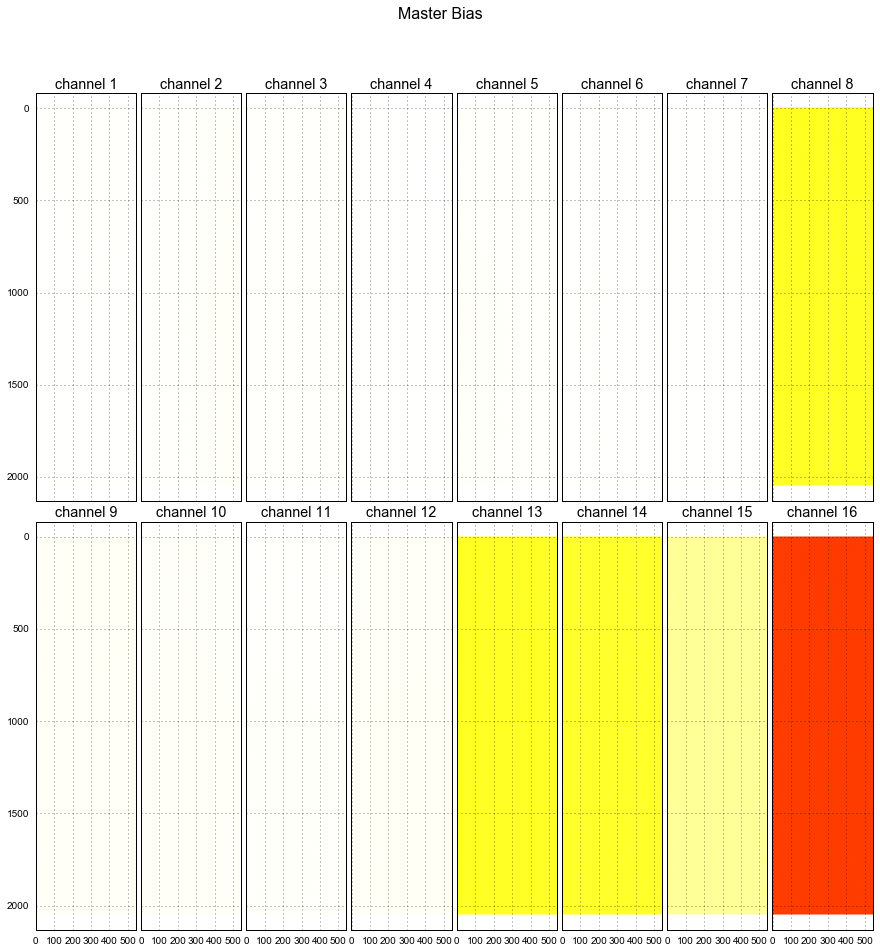

In [14]:

ShowImagesSet(allccdcombinedbias)

## 5) associate each individual bias with the masterbias

For each amplifier channel
- collection of bias
- the corresponding masterbias

In [15]:
bias_and_masterbias=zip(allccd, allccdcombinedbias)

## 6) substract masterbias

In [16]:
list_subbias= []
for allb,mb in bias_and_masterbias:
    list_b=[]
    for b in allb:
        nw=ccdproc.subtract_bias(b,mb)
        list_b.append(nw)
    list_subbias.append(list_b)        

## 5) Analysis of the result

Biases when average bias are substracted


In [17]:
def ShowHistoSet(allbiases,title='Master bias',lb=-80,hb=80):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''  
    NX=4 # number of images along the horizontal axis
    NY=4 # number of images along the vertical axis
    f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
    #f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
    f.subplots_adjust(hspace=0.5,wspace=0.5)
    index=-1
    binwidth=1
    # loop on channels indexes
    for bias in allbiases:    
        index=index+1  
        
        ix=index%4
        iy=index/4
        
        # loop on corrected bias file need an empty numpy array       
        image_data=np.array([]) # empty collector 
        for b in bias:        
            im_data = b.data  # extract np.array from CCDproc            
            dat=im_data.flatten()
            image_data=np.append(image_data,dat)
            
        # do some statistics 
        mean=image_data.mean()
        rms=image_data.std()
        print 'channel ',index+1,' mean bias = ',mean, ' bias rms = ',rms 
        
        # plot
        axarr[iy,ix].hist(image_data,bins=np.arange(min(image_data), max(image_data) + binwidth, binwidth),facecolor='blue', alpha=0.75,log=True)  # plot the image
        #axarr[iy,ix].hist(image_data,bins=500,facecolor='blue', alpha=0.75,log=False)  # plot the image
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_title(plottitle)
        axarr[iy,ix].set_xlabel('ADU')
        if title == 'Master bias' :
            axarr[iy,ix].set_xlim(lb,hb)
        else:
            axarr[iy,ix].set_xlim(2000.,4000.)
            
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_yscale('log')
        
    #plt.yscale('log')
    plt.suptitle(title,size=16)
    plt.savefig('masterbiashistos.pdf', bbox_inches='tight')

In [18]:
# plt.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth))

channel  1  mean bias =  0.0174551571117  bias rms =  1.87533960705
channel  2  mean bias =  -0.00254651237937  bias rms =  1.80044990484
channel  3  mean bias =  0.000466021369485  bias rms =  1.90376694833
channel  4  mean bias =  -0.0175701545267  bias rms =  1.93747998503
channel  5  mean bias =  -0.0156482292624  bias rms =  1.94633756072
channel  6  mean bias =  0.0183664119945  bias rms =  1.83108440774
channel  7  mean bias =  -0.0288495950138  bias rms =  1.88840178659
channel  8  mean bias =  -0.0123184563132  bias rms =  1.8457755004
channel  9  mean bias =  0.0112953634823  bias rms =  2.56903545182
channel  10  mean bias =  0.0217495548024  bias rms =  2.42844590422
channel  11  mean bias =  0.0235635016946  bias rms =  9.40625348305
channel  12  mean bias =  0.0206689453125  bias rms =  2.7347055465
channel  13  mean bias =  0.0182038789637  bias rms =  2.50352276579
channel  14  mean bias =  0.0275785378849  bias rms =  2.38189382744
channel  15  mean bias =  -0.00544830

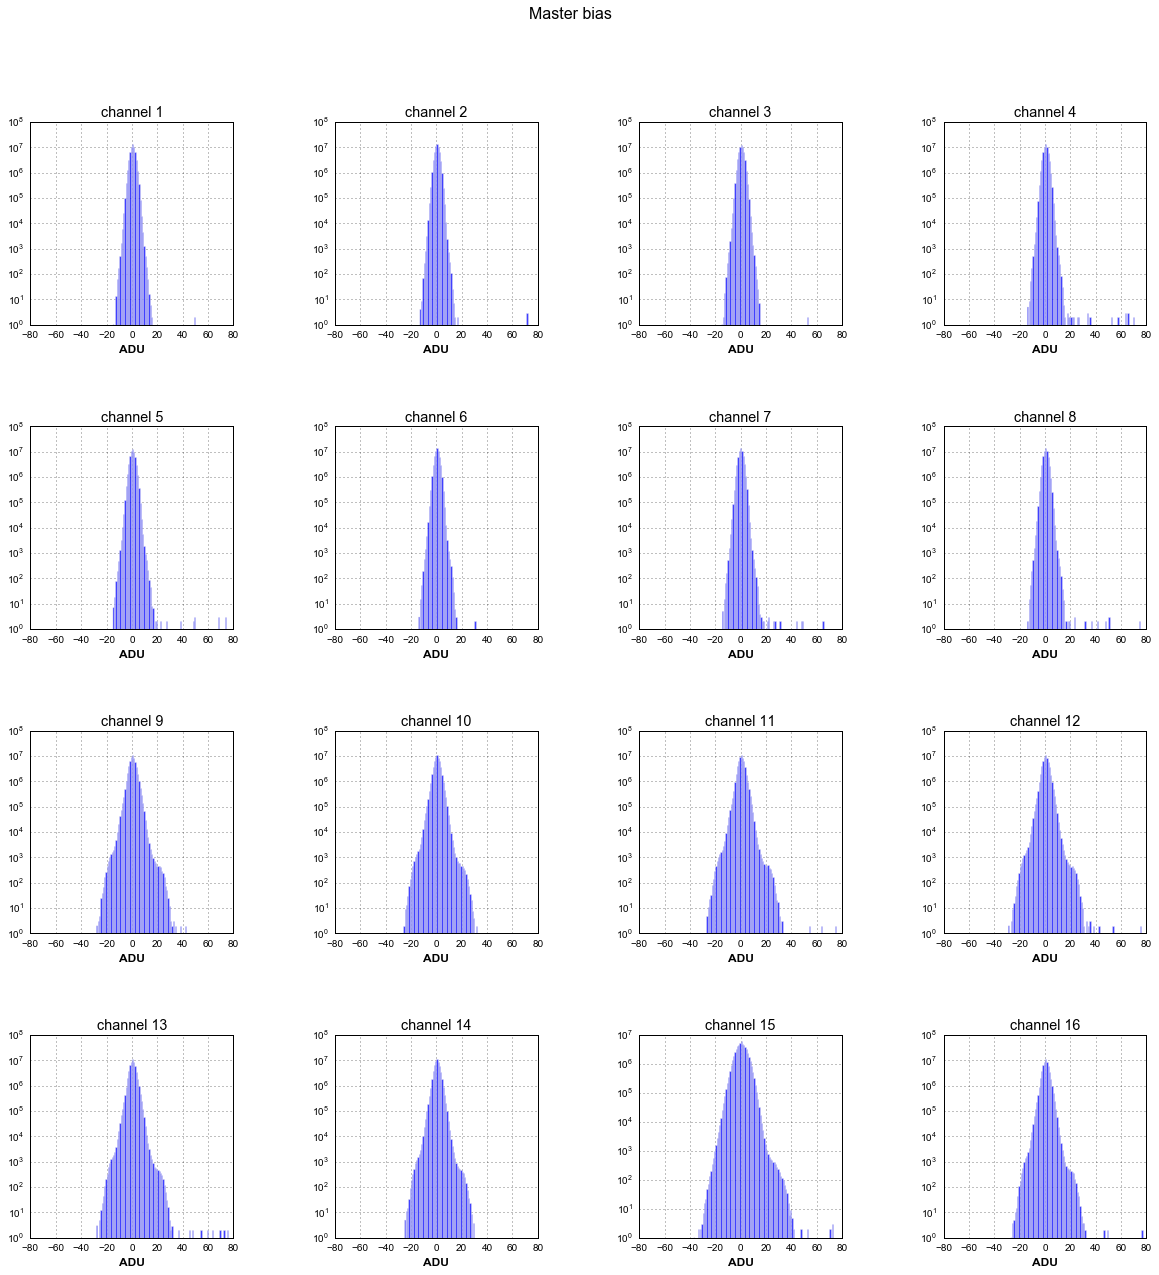

In [19]:
ShowHistoSet(list_subbias)

## 6) Check the initial bias distribution

channel  1  mean bias =  2969.62846868  bias rms =  14.7005789149
channel  2  mean bias =  3101.08453046  bias rms =  15.930573123
channel  3  mean bias =  3083.30683558  bias rms =  15.0884966931
channel  4  mean bias =  3171.98618844  bias rms =  15.4729864992
channel  5  mean bias =  3096.16383103  bias rms =  15.5120190457
channel  6  mean bias =  3032.72788933  bias rms =  15.7030494439
channel  7  mean bias =  3005.9252937  bias rms =  15.081816732
channel  8  mean bias =  2219.40071138  bias rms =  7.83323624592
channel  9  mean bias =  3676.36224078  bias rms =  10.4916792622
channel  10  mean bias =  3786.95976656  bias rms =  11.6704622846
channel  11  mean bias =  3767.48725746  bias rms =  14.9274893923
channel  12  mean bias =  3777.27684651  bias rms =  12.2231498696
channel  13  mean bias =  3650.49652832  bias rms =  11.9104765703
channel  14  mean bias =  3556.74851189  bias rms =  11.9991909896
channel  15  mean bias =  3566.34222859  bias rms =  12.449140713
channel 

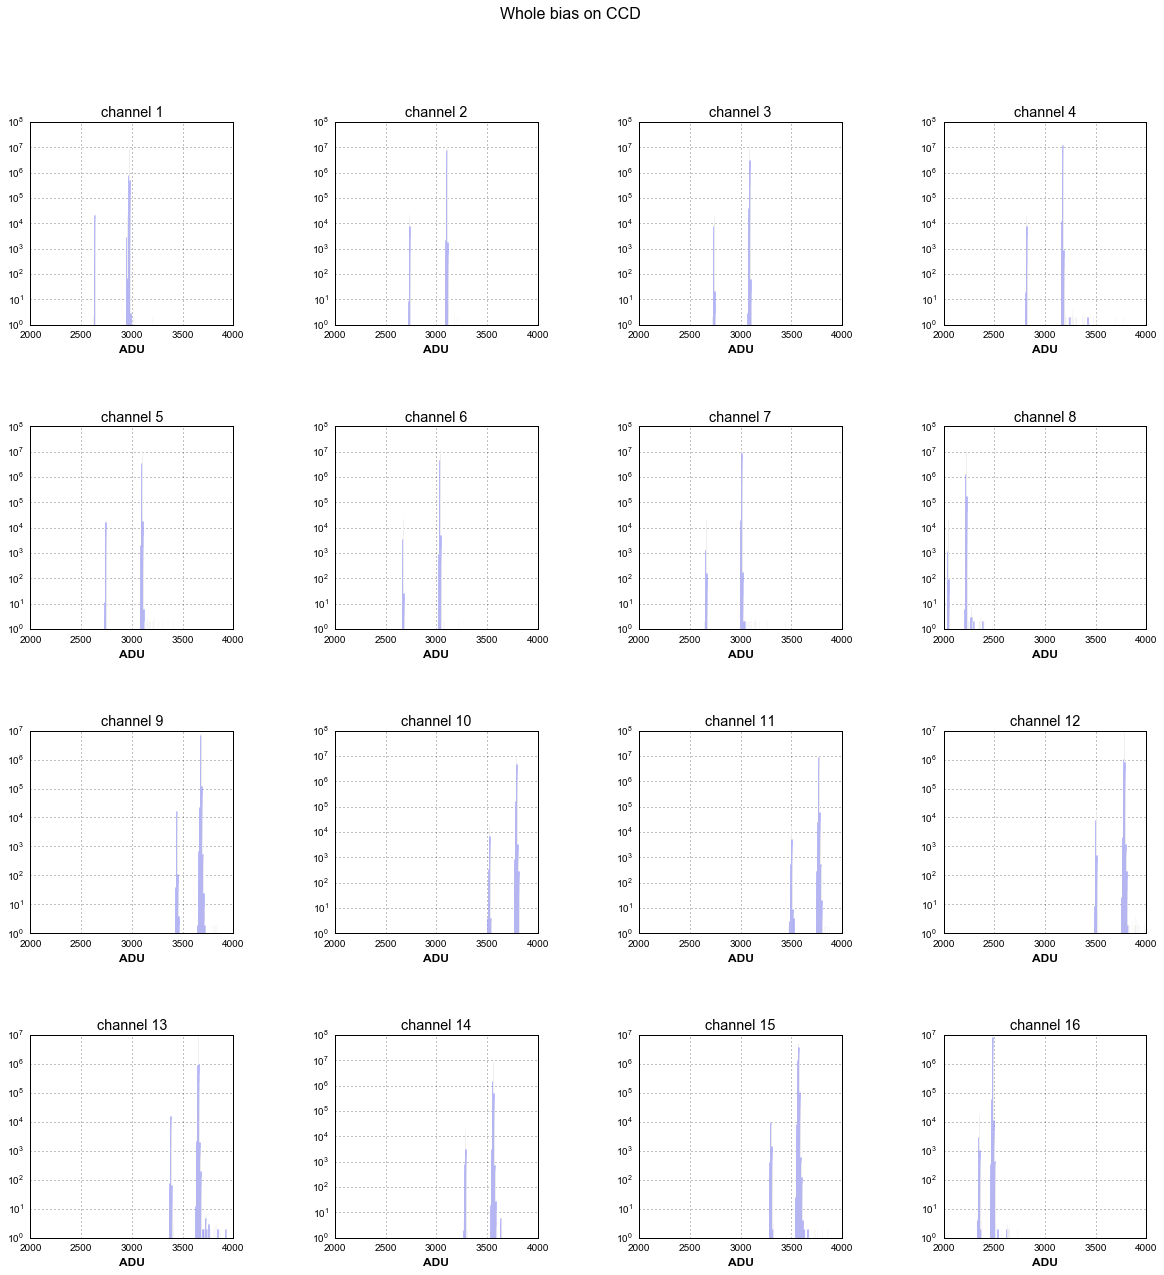

In [20]:
ShowHistoSet(allccd,title='Whole bias on CCD')

## 7) Save the Master Bias in a fits file

- save all the masterbiases for all the amplifier channels inside the file : out_master_bias_fitsfile

In [22]:
out_master_bias_fitsfile='masterbias_outtest.fits'
hdul = fits.HDUList() 
hdul.append(fits.PrimaryHDU()) 

hdul.info()
header=hdul[0].header


header['IMAGETYP']='master_bias'
header['DATE-ANA']=date_of_analysis

print repr(header)

index=0
for mbchan in allccdcombinedbias :
    index=index+1
    img=mbchan.data
    hdul.append(fits.ImageHDU(data=img)) 
    
hdul.writeto(out_master_bias_fitsfile) 
    
    

Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
IMAGETYP= 'master_bias'                                                         
DATE-ANA= '2016-06-06T07:36:25'                                                 


In [23]:
hdu_list = fits.open(out_master_bias_fitsfile)
hdu_list.info()

Filename: masterbias_outtest.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   ()              
1                ImageHDU         7   (544, 2048)   float64   
2                ImageHDU         7   (544, 2048)   float64   
3                ImageHDU         7   (544, 2048)   float64   
4                ImageHDU         7   (544, 2048)   float64   
5                ImageHDU         7   (544, 2048)   float64   
6                ImageHDU         7   (544, 2048)   float64   
7                ImageHDU         7   (544, 2048)   float64   
8                ImageHDU         7   (544, 2048)   float64   
9                ImageHDU         7   (544, 2048)   float64   
10               ImageHDU         7   (544, 2048)   float64   
11               ImageHDU         7   (544, 2048)   float64   
12               ImageHDU         7   (544, 2048)   float64   
13               ImageHDU         7   (544, 2048)   float64   
14               ImageHDU         

In [ ]:
header=hdu_list[0].header
header

In [ ]:
image_data1 = hdu_list[2].data

In [ ]:
NX=1
NY=1
fig, axarr = plt.subplots(NY,NX,figsize=(5,5))

plt.imshow(image_data1,interpolation='nearest')
plt.colorbar()
title='Bias 1'

plt.suptitle(title,size=16)
plt.show()

In [ ]:
NX=1
NY=1
fig, axarr = plt.subplots(NY,NX,figsize=(5,5))

#plt.hist(image_data1)
binwidth=1
data=image_data1.flatten()
plt.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth),log=True)
title='Bias 1'
#plt.xlim(2950,2980)
plt.suptitle(title,size=16)
plt.show()

## 8) Check the Master Bias in DS9

In [ ]:
import pyds9

In [ ]:
print(pyds9.ds9_targets())

In [ ]:
d = pyds9.DS9()

In [ ]:
# define the zoom
ds9command='zoom 0.125'
d.set(ds9command)
# set the scale
ds9command='scale histequ zscale'
d.set(ds9command)

for channel in range(1,nb_of_channels+1):
    # select the frame
    ds9command='frame '+ str(channel)
    d.set(ds9command)    
    # set the scale
    ds9command='scale histequ'
    d.set(ds9command)
    ds9command='scale zscale'
    d.set(ds9command)
    # set the color
    ds9command='cmap rainbow'
    d.set(ds9command)
    # define the image
    filelist=out_master_bias_fitsfile+'['+str(channel) + ']' 
    ds9command = 'file '+ filelist
    d.set(ds9command)  # send the file to the open ds9 session


In [ ]:
def SaveCCDListIntoFitsFime(ccdlist,outfitsfilename,imagetyp='master_bias',date='None'):
	'''
		inputs : 
		- ccdlist : list of CCDData images to be written in the file
		- outfitsfilename : string of the output fits filename
		
	'''
	# first create the HDU list and the primary  HDU (header)
	
	hdul = fits.HDUList() 
	hdul.append(fits.PrimaryHDU()) 

	hdul.info()
	header=hdul[0].header


	header['IMAGETYP']=imagetyp
	header['DATE-ANA']=date

	print repr(header)

	index=0
	
	for mbchan in ccdlist :
	    index=index+1
					
	    img=mbchan.data
	    hdul.append(fits.ImageHDU(data=img)) 
    
	    hdul.writeto(out_master_bias_fitsfile) 

    hdul.close()
					